In [1]:
import math
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (cluster_utils,
                                            nn_utils,
                                            portfolio_utils,
                                            random_forest_utils,
                                            time_series_utils)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [2]:
date_start = '2005-01-01'
date_end = '2019-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker !~ '[\^.~]'
        and character_length(ticker) between 1 and 4
    limit 60
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,open
0,AEF,2005-01-03 06:00:00,26.780
1,AEP,2005-01-03 06:00:00,34.210
2,ACH,2005-01-03 06:00:00,14.775
3,ABG,2005-01-03 06:00:00,13.800
4,AE,2005-01-03 06:00:00,17.690


In [3]:
query = f"""
    select distinct 
        ticker as symbol
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker !~ '[\^.~]'
        and character_length(ticker) between 1 and 4
    limit 60
    """

ticker_attributes = utils.query_db(query=query)
ticker_attributes.head()

,symbol,sector,industry
0,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments
1,AA,Basic Industries,Aluminum
2,AAC,Health Care,Medical Specialities
3,AAMC,Finance,Real Estate
4,AAN,Technology,Diversified Commercial Services


### Check data

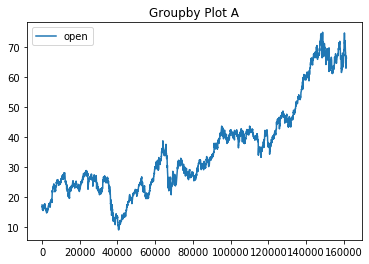

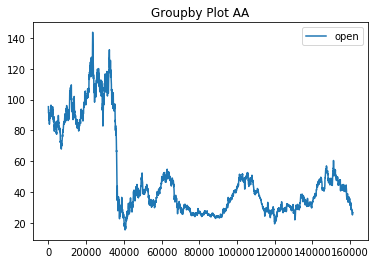

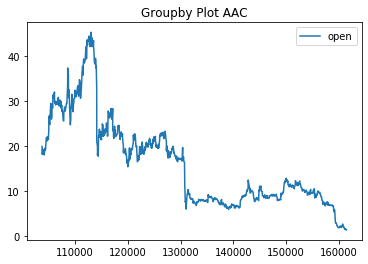

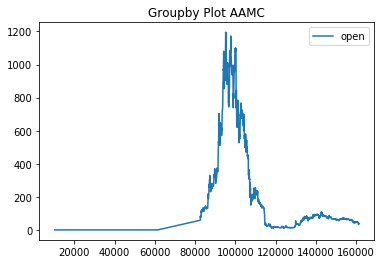

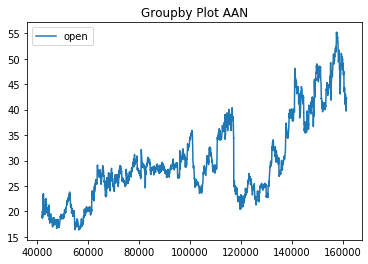

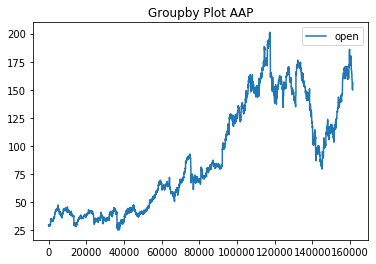

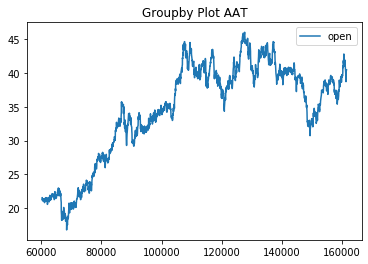

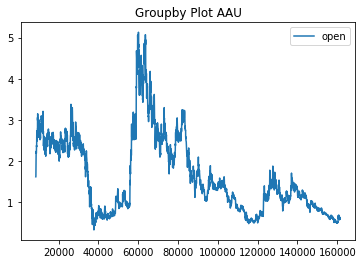

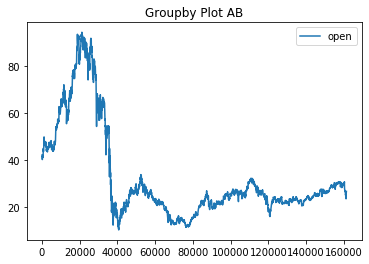

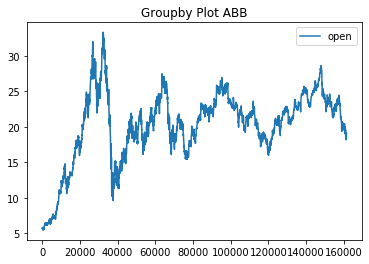

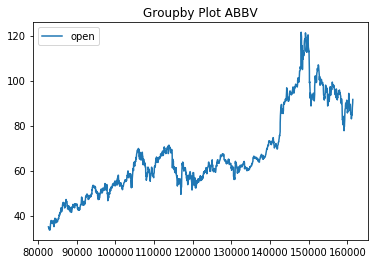

In [4]:
cluster_utils.plot_groupby(df, 'symbol', lines=['open'])

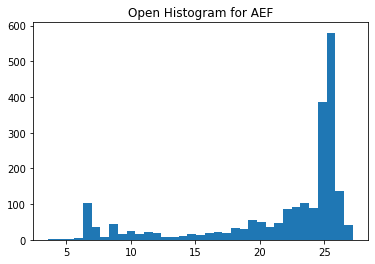

In [5]:
plt.hist(df.loc[df['symbol']==df['symbol'].values[0], 'open'], bins=35)
plt.title('Open Histogram for ' + df['symbol'].values[0])
plt.show()

### Clean data

In [6]:
def normalize(df, column='open', window_size=1000):
    df['open_min'] = df[column].rolling(window_size).min()
    df['open_max'] = df[column].rolling(window_size).max()
    df[column] = ((df[column] - df['open_min']) / (df['open_max'] - df['open_min']))
    return df

In [7]:
df['target'] = df['open']
df['open_min'], df['open_max'] = 0, 0

df = df.groupby('symbol').apply(normalize)
df = df[df['open'].notnull()]

In [8]:
df = cluster_utils.encode_one_hot(df, ['symbol'])

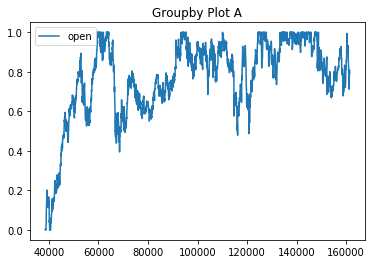

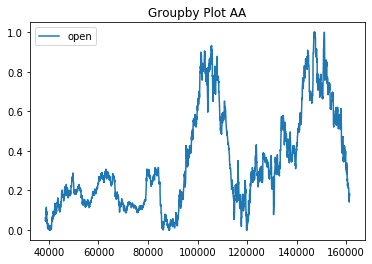

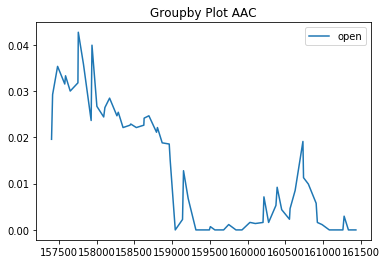

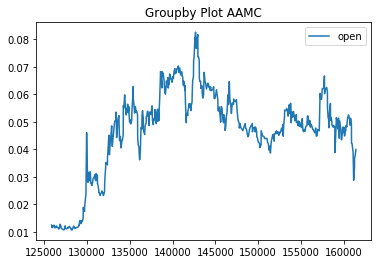

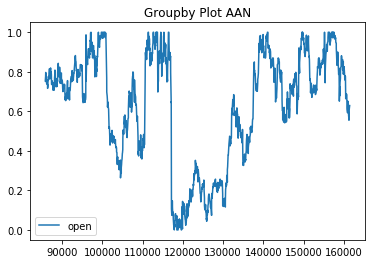

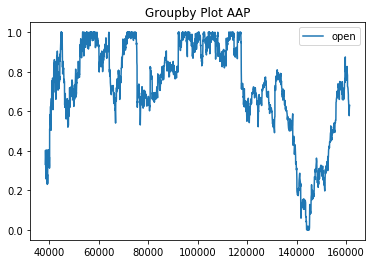

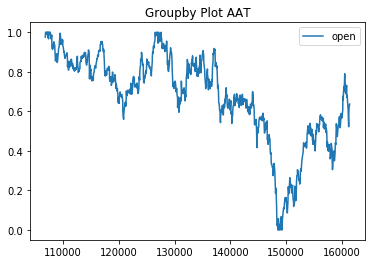

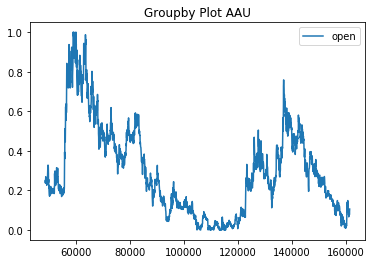

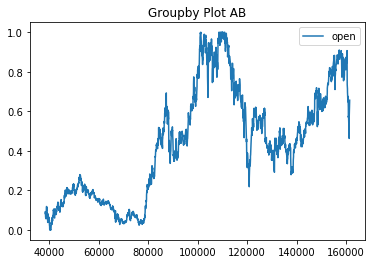

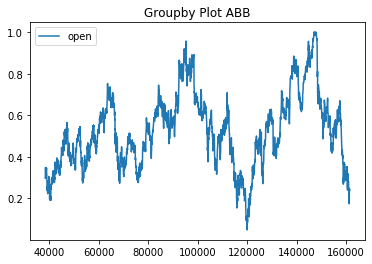

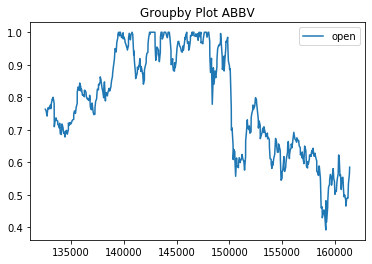

In [9]:
cluster_utils.plot_groupby(df, 'symbol', lines=['open'])

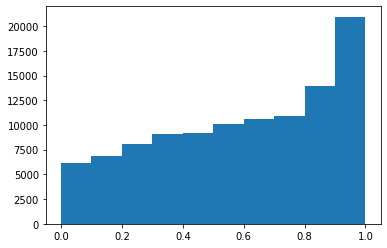

In [10]:
plt.hist(df['open'])
plt.show()

In [11]:
def sequence_data(df, column='open', length=100):
    dfs = []
    for offset in range(1, length, 1):
        df = df.join(df[column].shift(offset), rsuffix='_' + str(abs(offset)))
    return df

train_test = df.groupby('symbol').apply(sequence_data)


train_test = train_test.dropna()
train_test = train_test.sort_values(by='market_datetime')

print(train_test.shape)
train_test.head(10)

(100815, 155)


,symbol,market_datetime,open,target,open_min,open_max,symbol_A,symbol_AA,symbol_AAC,symbol_AAMC,...,open_90,open_91,open_92,open_93,open_94,open_95,open_96,open_97,open_98,open_99
42572,AES,2009-05-12 05:00:00,0.215270,9.04000,4.980000,23.840000,0,0,0,0,...,0.087536,0.075942,0.067826,0.062029,0.060290,0.073043,0.075942,0.099130,0.055072,0.071304
42611,ABM,2009-05-12 05:00:00,0.251813,16.76000,11.900000,31.200000,0,0,0,0,...,0.290055,0.268508,0.279558,0.275691,0.278453,0.272376,0.274033,0.271823,0.267956,0.251381
42610,ADC,2009-05-12 05:00:00,0.269300,16.84000,9.410000,37.000000,0,0,0,0,...,0.270011,0.243821,0.339727,0.309111,0.313537,0.253781,0.216894,0.225009,0.237920,0.256732
42601,ABT,2009-05-12 05:00:00,0.322470,21.56084,17.962582,29.121011,0,0,0,0,...,0.673671,0.641509,0.670240,0.654803,0.645798,0.669382,0.636792,0.662950,0.635077,0.646655
42597,ABG,2009-05-12 05:00:00,0.269299,9.52000,1.950000,30.060000,0,0,0,0,...,0.089648,0.088225,0.082177,0.069015,0.062255,0.069370,0.092494,0.094628,0.103522,0.083600
42596,ADX,2009-05-12 05:00:00,0.267380,8.50000,6.000000,15.350000,0,0,0,0,...,0.091463,0.075610,0.074390,0.064634,0.079268,0.074390,0.109756,0.101220,0.128049,0.093902
42595,ABR,2009-05-12 05:00:00,0.059332,2.42000,0.430000,33.970000,0,0,0,0,...,0.023581,0.019547,0.032578,0.039094,0.043438,0.041266,0.040025,0.023891,0.024511,0.027304
42589,ACC,2009-05-12 05:00:00,0.353783,22.27000,15.350000,34.910000,0,0,0,0,...,0.167698,0.137310,0.198649,0.218908,0.196398,0.230163,0.271806,0.311761,0.289814,0.229038
42588,ABC,2009-05-12 05:00:00,0.297857,17.87000,13.770000,27.535000,0,0,0,0,...,0.284978,0.266844,0.264356,0.260444,0.258311,0.264711,0.277156,0.268267,0.257244,0.283911
42600,AEE,2009-05-12 05:00:00,0.125719,24.37000,19.780000,56.290000,0,0,0,0,...,0.149855,0.117925,0.125544,0.119376,0.107765,0.143687,0.145864,0.148766,0.146952,0.139332


### Train lstm

In [ ]:
cols_to_ignore = ['symbol', 'market_datetime', 'open', 'open_min', 'open_max', 'target']

data_size = int(round(len(train_test)/2, -2))
model = nn_utils.TorchLSTM(train_x=train_test.drop(cols_to_ignore, axis=1).head(data_size), 
                           train_y=train_test['open'].head(data_size), 
                           test_x=train_test.drop(cols_to_ignore, axis=1).tail(data_size), 
                           test_y=train_test['open'].tail(data_size),
                           n_layers=2,
                           n_epochs=500,
                           hidden_shape=1000,
                           batch_size=int(data_size/100),
                           dropout=.1,
                           learning_rate=.0001,
                           device='cuda:0',
                           seed=6
                          )

model.execute()
model.reset_network()

Epoch  0 Error:  31033.333984375
Epoch  50 Error:  9352.9404296875
Epoch  100 Error:  3599.835693359375
Epoch  150 Error:  2606.341552734375
Epoch  200 Error:  2210.45947265625
Epoch  250 Error:  2018.674560546875
Epoch  300 Error:  1827.417236328125
Epoch  350 Error:  1695.2396240234375
Epoch  400 Error:  1594.069580078125


In [ ]:
model.predict()[0][0]

### Analyze predictions

In [13]:
test_df = model.test_df

temp = train_test[cols_to_ignore].tail(data_size).reset_index(drop=True)
test_df = test_df.join(temp)
test_df.head()

,symbol_A,symbol_AA,symbol_AAC,symbol_AAMC,symbol_AAN,symbol_AAP,symbol_AAT,symbol_AAU,symbol_AB,symbol_ABB,...,open_98,open_99,actuals,prediction,symbol,market_datetime,open,open_min,open_max,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.808917,0.823248,0.928344,0.983693,AES,2014-07-18 05:00:00,0.928344,9.29,15.5700,15.120
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.866310,0.874191,0.890796,0.854037,AFL,2014-07-18 05:00:00,0.890797,15.86,33.6250,31.685
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.773060,0.775256,0.729868,0.737642,ADC,2014-07-18 05:00:00,0.729868,20.14,33.8000,30.110
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.898876,0.905618,0.980507,0.985199,ADX,2014-07-18 05:00:00,0.980507,8.81,13.9400,13.840
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.958241,0.960957,0.756015,0.810902,AE,2014-07-18 05:00:00,0.756015,16.60,90.2758,72.300


In [14]:
test_df['prediction_mapped'] = (test_df['prediction'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['actuals_mapped'] = (test_df['actuals'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['errors'] = test_df['prediction'] - test_df['actuals']

test_df.head(10)

,symbol_A,symbol_AA,symbol_AAC,symbol_AAMC,symbol_AAN,symbol_AAP,symbol_AAT,symbol_AAU,symbol_AB,symbol_ABB,...,prediction,symbol,market_datetime,open,open_min,open_max,target,prediction_mapped,actuals_mapped,errors
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.983693,AES,2014-07-18 05:00:00,0.928344,9.2900,15.5700,15.120,15.467589,15.120000,0.055349
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.854037,AFL,2014-07-18 05:00:00,0.890797,15.8600,33.6250,31.685,31.031963,31.685000,-0.036760
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.737642,ADC,2014-07-18 05:00:00,0.729868,20.1400,33.8000,30.110,30.216188,30.110000,0.007774
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.985199,ADX,2014-07-18 05:00:00,0.980507,8.8100,13.9400,13.840,13.864071,13.840000,0.004692
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.810902,AE,2014-07-18 05:00:00,0.756015,16.6000,90.2758,72.300,76.343832,72.300001,0.054887
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.062182,AEO,2014-07-18 05:00:00,0.029927,10.1100,23.8100,10.520,10.961897,10.520000,0.032255
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.740461,ABM,2014-07-18 05:00:00,0.682800,17.5400,29.1100,25.440,26.107133,25.440000,0.057661
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.695162,AGCO,2014-07-18 05:00:00,0.654374,31.6300,64.4400,53.100,54.438250,53.099999,0.040788
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.728867,ABR,2014-07-18 05:00:00,0.700199,3.0799,8.2500,6.700,6.848213,6.700000,0.028667
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.567586,ACC,2014-07-18 05:00:00,0.594011,27.7000,48.0700,39.800,39.261727,39.800001,-0.026425


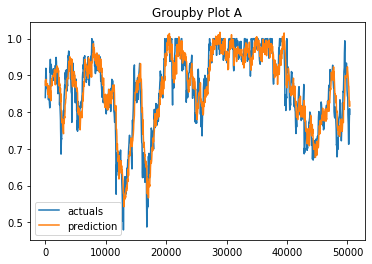

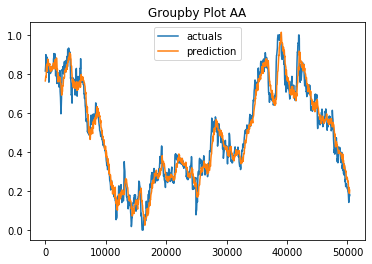

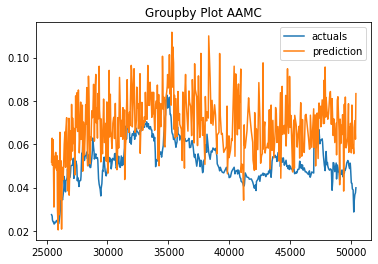

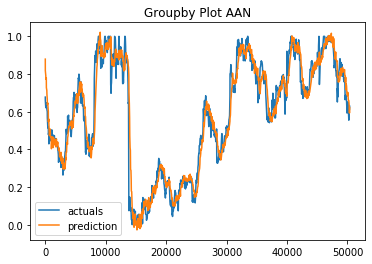

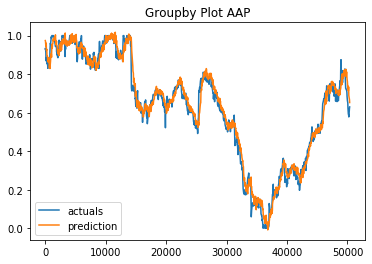

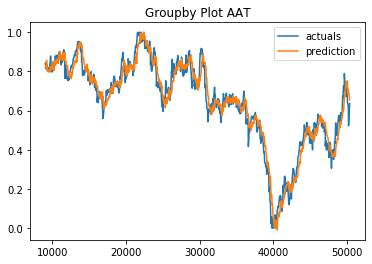

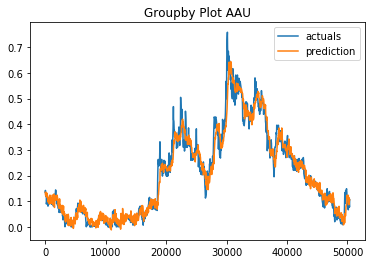

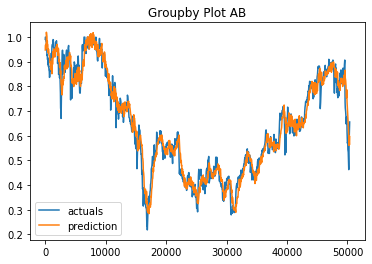

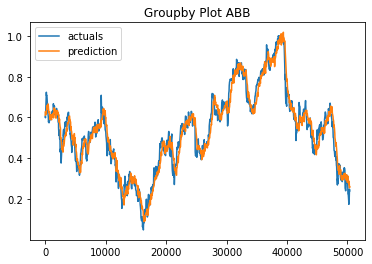

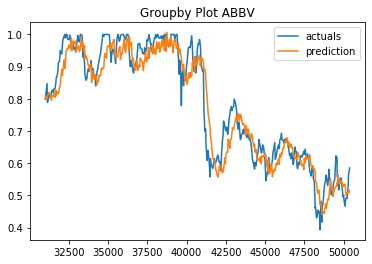

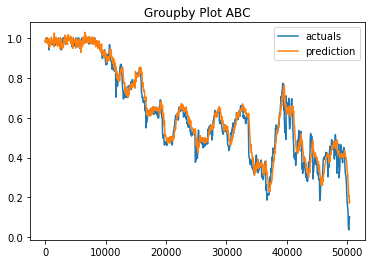

In [15]:
cluster_utils.plot_groupby(test_df, 'symbol', lines=['actuals', 'prediction'])

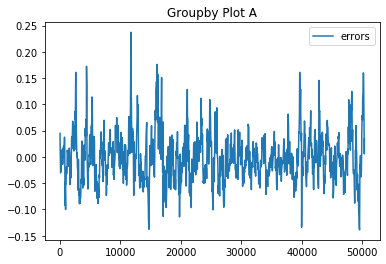

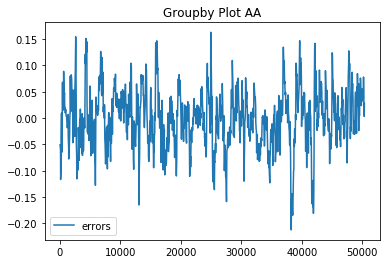

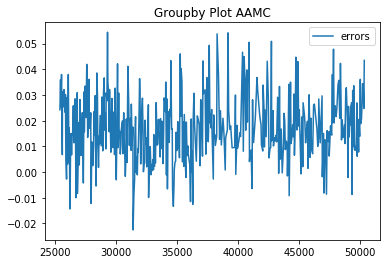

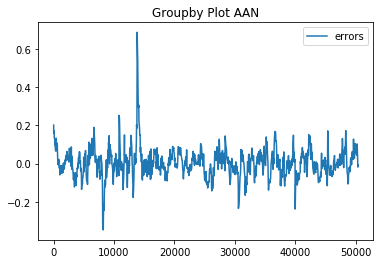

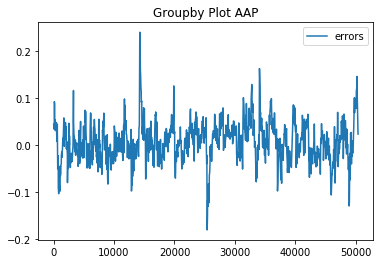

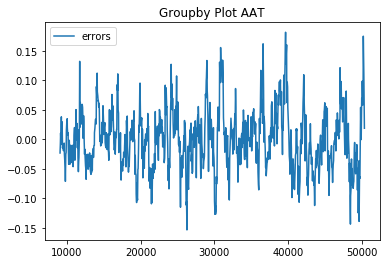

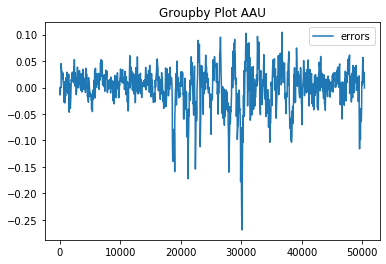

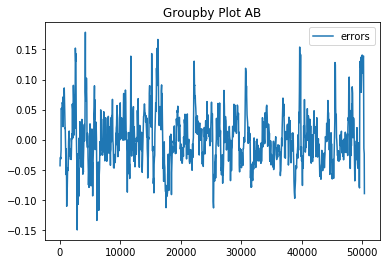

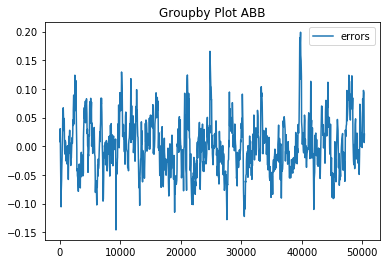

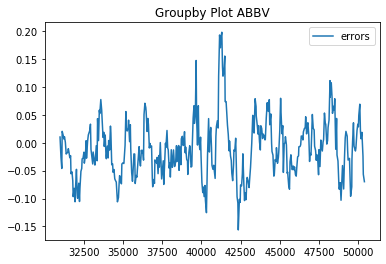

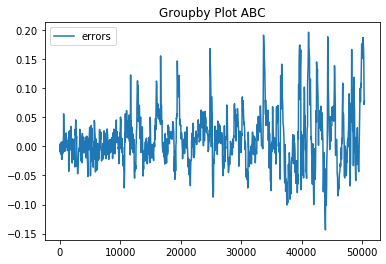

In [16]:
cluster_utils.plot_groupby(test_df, 'symbol', lines=['errors'])

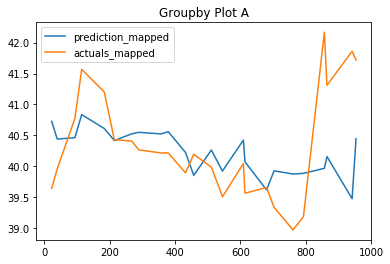

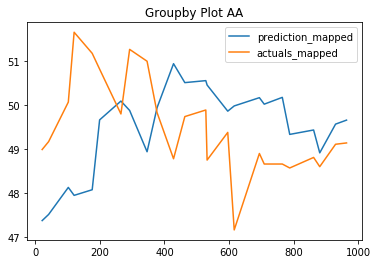

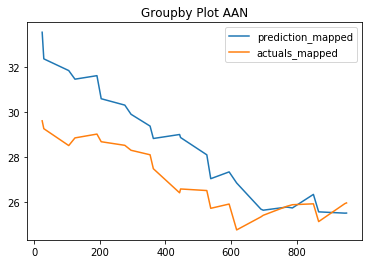

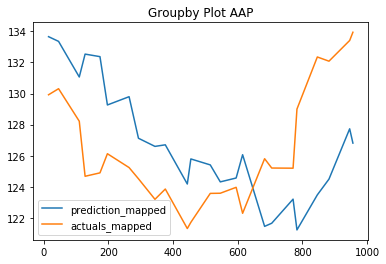

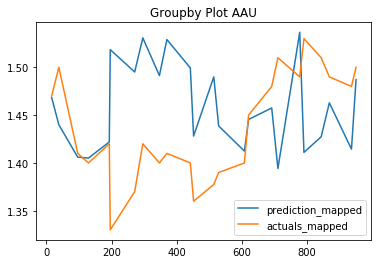

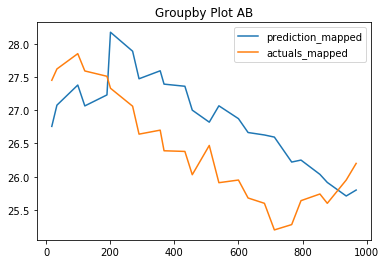

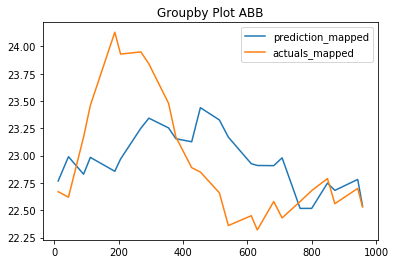

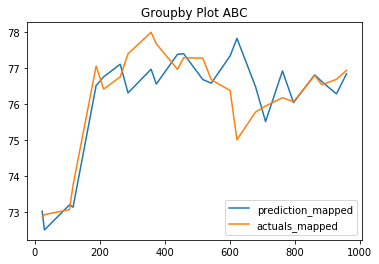

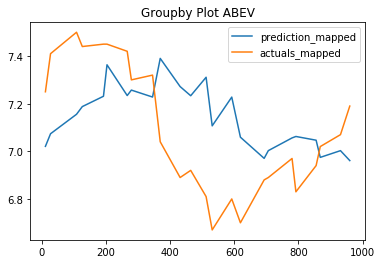

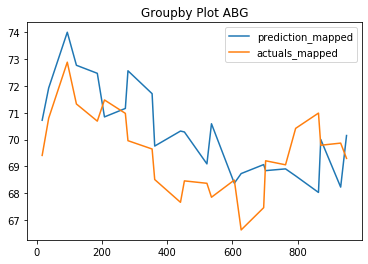

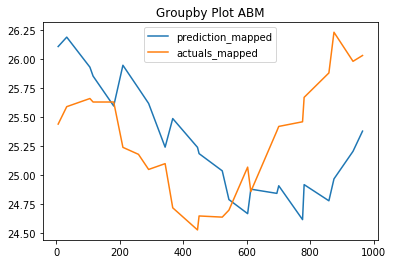

In [17]:
cluster_utils.plot_groupby(test_df.head(1000), 'symbol', lines=['prediction_mapped', 'actuals_mapped'])

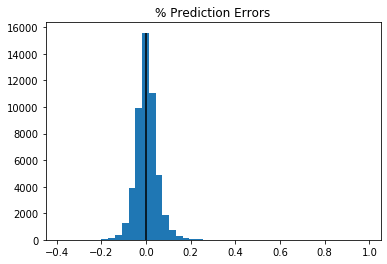

In [18]:
plt.title('% Prediction Errors')
plot = plt.hist(test_df['errors'], bins=45)
plt.vlines(0, ymin=0, ymax=plot[0].max())
plt.show()

### Size bets

In [19]:
cols = ['symbol', 'market_datetime', 'prediction_mapped', 'actuals_mapped']

trades = test_df[cols]
trades = trades.join(test_df.groupby('symbol')['actuals_mapped'].shift(1), rsuffix='_t-1')
trades = trades.dropna()

# determine trade direction(s)
trades['current_trade'] = 'neutral'
trades.loc[trades['prediction_mapped'] > trades['actuals_mapped_t-1'], 'current_trade'] = 'long'
trades.loc[trades['prediction_mapped'] < trades['actuals_mapped_t-1'], 'current_trade'] = 'short'

# predict profits
trades['predicted_profits'] = abs(trades['prediction_mapped'] - trades['actuals_mapped_t-1'])

# calculate actual profits
trades['actual_profits'] = 0
trades.loc[trades['current_trade']=='long', 'actual_profits'] = trades.loc[trades['current_trade']=='long', 'actuals_mapped'] - trades.loc[trades['current_trade']=='long', 'actuals_mapped_t-1']
trades.loc[trades['current_trade']=='short', 'actual_profits'] = trades.loc[trades['current_trade']=='short', 'actuals_mapped_t-1'] - trades.loc[trades['current_trade']=='short', 'actuals_mapped']

trades[trades['symbol']==trades['symbol'].values[0]].head(10)

,symbol,market_datetime,prediction_mapped,actuals_mapped,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits
27,ABEV,2014-07-21 05:00:00,7.073814,7.41,7.25,short,0.176186,-0.16
108,ABEV,2014-07-22 05:00:00,7.155566,7.50,7.41,short,0.254434,-0.09
126,ABEV,2014-07-23 05:00:00,7.187781,7.44,7.50,short,0.312219,0.06
192,ABEV,2014-07-24 05:00:00,7.231206,7.45,7.44,short,0.208794,-0.01
203,ABEV,2014-07-25 05:00:00,7.363306,7.45,7.45,short,0.086694,0.00
266,ABEV,2014-07-28 05:00:00,7.234228,7.42,7.45,short,0.215772,0.03
279,ABEV,2014-07-29 05:00:00,7.257115,7.30,7.42,short,0.162885,0.12
345,ABEV,2014-07-30 05:00:00,7.227934,7.32,7.30,short,0.072066,-0.02
369,ABEV,2014-07-31 05:00:00,7.390143,7.04,7.32,long,0.070143,-0.28
431,ABEV,2014-08-01 05:00:00,7.271875,6.89,7.04,long,0.231875,-0.15


In [20]:
kwargs = {"profits": 'actual_profits'} 
trades = trades.groupby('symbol').apply(portfolio_utils.get_estimated_loss, **kwargs)

trades['kelly'] = portfolio_utils.kelly_criterion(trades['predicted_profits'], 
                                                  trades['estimated_loss'], 
                                                  trades['profit_rate'])

trades = trades.dropna()
trades.tail(10)

,symbol,market_datetime,prediction_mapped,actuals_mapped,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits,profit_rate,estimated_loss,kelly
50390,ABM,2018-12-31 06:00:00,28.986047,31.340000,31.040000,short,2.053953,-0.300000,0.48,0.405000,0.377466
50391,ACY,2018-12-31 06:00:00,10.651038,9.270000,8.709500,long,1.941538,0.560500,0.47,0.200000,0.415404
50392,ACRE,2018-12-31 06:00:00,13.406343,13.100000,13.090000,long,0.316343,0.010000,0.53,0.080000,0.411142
50393,ABC,2018-12-31 06:00:00,77.822048,74.090000,73.900000,long,3.922048,0.190000,0.54,0.890000,0.435616
50394,ACN,2018-12-31 06:00:00,149.403455,140.400001,141.010002,long,8.393453,-0.610001,0.47,1.114998,0.399594
50395,AEO,2018-12-31 06:00:00,18.229955,19.090000,19.350000,short,1.120044,0.260000,0.40,0.380000,0.196437
50396,ADM,2018-12-31 06:00:00,42.170758,40.840000,41.130000,long,1.040758,-0.290000,0.53,0.315000,0.387748
50397,ADC,2018-12-31 06:00:00,60.224344,59.330001,59.220000,long,1.004344,0.110000,0.47,0.430000,0.243086
50398,AEG,2018-12-31 06:00:00,4.530810,4.620000,4.600000,short,0.069190,-0.020000,0.46,0.072500,-0.105831
50399,AGCO,2018-12-31 06:00:00,55.092275,54.900000,54.880000,long,0.212275,0.020001,0.53,0.690000,-0.997736


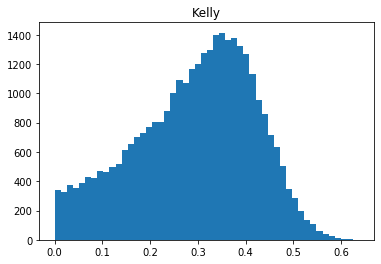

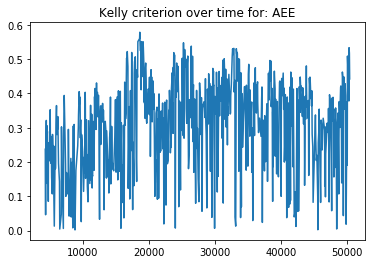

In [21]:
plt.title('Kelly')
plt.hist(trades.loc[trades['kelly'] > 0, 'kelly'], bins=50)
plt.show()

plt.title('Kelly criterion over time for: ' + trades['symbol'].values[0])
plt.plot(trades.loc[(trades['symbol']==trades['symbol'].values[0]) & (trades['kelly'] > 0), 'kelly'])
plt.show()

### Allocation method: greedy kelly

In [22]:
trades['half_kelly'] = trades['kelly']/2
trades['quarter_kelly'] = trades['kelly']/4
trades['eighth_kelly'] = trades['kelly']/8
positions, budget = portfolio_utils.greedy_kelly(
    trades, 
    price='actuals_mapped', 
    profits='actual_profits',
    kelly='quarter_kelly'
)

Annualized P/L 0.87143


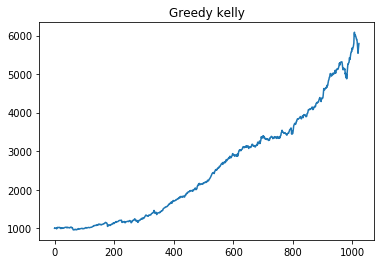

,symbol,market_datetime,prediction_mapped,actuals_mapped,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits,profit_rate,estimated_loss,kelly,half_kelly,quarter_kelly,eighth_kelly,position,n_shares
4176,AES,2014-12-09 06:00:00,13.832187,13.470000,13.65,long,0.182187,-0.180000,0.55,0.130000,0.228901,0.114450,0.057225,0.028613,53.879999,4
4181,AGCO,2014-12-09 06:00:00,43.240227,43.050000,43.71,short,0.469772,0.660000,0.57,0.355000,0.245055,0.122528,0.061264,0.030632,43.050000,1
4184,AEO,2014-12-09 06:00:00,13.113348,12.390000,11.90,long,1.213348,0.490000,0.55,0.170000,0.486951,0.243476,0.121738,0.060869,111.509999,9
4195,ABC,2014-12-09 06:00:00,91.246361,91.449999,92.01,short,0.763639,0.560000,0.64,0.414999,0.444358,0.222179,0.111090,0.055545,91.449999,1
4197,ACM,2014-12-09 06:00:00,31.501791,29.700001,30.76,long,0.741791,-1.059999,0.49,0.320000,0.269992,0.134996,0.067498,0.033749,59.400001,2


In [23]:
annualized_return = portfolio_utils.annualized_return(
    budget[0], 
    budget[-1], 
    len(budget))
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.title('Greedy kelly')
plt.plot(budget)
plt.show()

positions.head()

### Allocation method: n largest kelly

In [24]:
positions = portfolio_utils.n_largest_kelly(trades, 
                                            price='actuals_mapped', 
                                            profits='actual_profits',
                                            kelly='quarter_kelly'
                                           )

Annualized P/L 0.448598


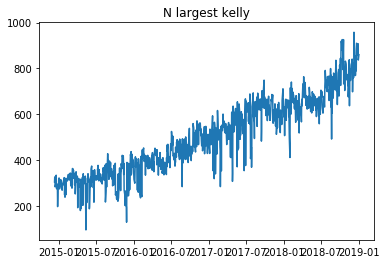

,symbol,market_datetime,prediction_mapped,actuals_mapped,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits,profit_rate,estimated_loss,kelly,half_kelly,quarter_kelly,eighth_kelly,position,n_shares,quarter_kelly_adj
4184,AEO,2014-12-09 06:00:00,13.113348,12.390000,11.900000,long,1.213348,0.490000,0.55,0.170000,0.486951,0.243476,0.121738,0.060869,111.509999,9,0.361809
4195,ABC,2014-12-09 06:00:00,91.246361,91.449999,92.010000,short,0.763639,0.560000,0.64,0.414999,0.444358,0.222179,0.111090,0.055545,91.449999,1,0.330162
4212,ABEV,2014-12-09 06:00:00,6.382294,5.990000,6.110000,long,0.272294,-0.120000,0.56,0.090000,0.414569,0.207285,0.103642,0.051821,101.830000,17,0.308029
4226,ABC,2014-12-10 06:00:00,92.853709,91.920000,91.449999,long,1.403709,0.470001,0.65,0.430000,0.542784,0.271392,0.135696,0.067848,91.920000,1,0.354118
4248,AEB,2014-12-10 06:00:00,23.982557,23.370000,22.980000,long,1.002557,0.390000,0.54,0.090000,0.498706,0.249353,0.124676,0.062338,116.850000,5,0.325360


In [25]:
annualized_return = portfolio_utils.annualized_return(
    positions.groupby('market_datetime').sum()['position'][0], 
    positions.groupby('market_datetime').sum()['position'][-1], 
    len(positions.groupby('market_datetime')))
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.title('N largest kelly')
plt.plot(positions.groupby('market_datetime').sum()['position'])
plt.show()

positions.head()

### Allocation method: market neutral kelly

In [26]:
positions, budget = portfolio_utils.greedy_kelly_diversified(
    trades, 
    dimensions=['current_trade'],
    price='actuals_mapped', 
    profits='actual_profits',
    kelly='kelly'
)

Annualized P/L 0.763678


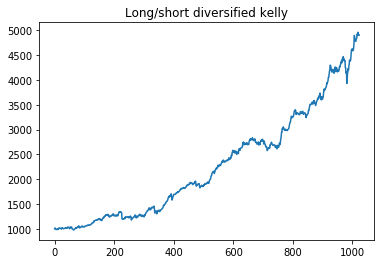

,symbol,market_datetime,prediction_mapped,actuals_mapped,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits,profit_rate,estimated_loss,kelly,half_kelly,quarter_kelly,eighth_kelly,position,n_shares,quarter_kelly_adj
4184,AEO,2014-12-09 06:00:00,13.113348,12.390000,11.900000,long,1.213348,0.490000,0.55,0.170000,0.486951,0.243476,0.121738,0.060869,235.409998,19,0
4212,ABEV,2014-12-09 06:00:00,6.382294,5.990000,6.110000,long,0.272294,-0.120000,0.56,0.090000,0.414569,0.207285,0.103642,0.051821,203.660001,34,0
4195,ABC,2014-12-09 06:00:00,91.246361,91.449999,92.010000,short,0.763639,0.560000,0.64,0.414999,0.444358,0.222179,0.111090,0.055545,182.899999,2,0
4201,ACH,2014-12-09 06:00:00,10.771780,10.720000,11.210000,short,0.438220,0.490000,0.50,0.150000,0.328853,0.164427,0.082213,0.041107,160.800001,15,0
4226,ABC,2014-12-10 06:00:00,92.853709,91.920000,91.449999,long,1.403709,0.470001,0.65,0.430000,0.542784,0.271392,0.135696,0.067848,183.840001,2,0


In [27]:
annualized_return = portfolio_utils.annualized_return(
    budget[0], 
    budget[-1], 
    len(budget))
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.title('Long/short diversified kelly')
plt.plot(budget)
plt.show()

positions.head()

### Allocation method: sector neutral kelly

In [28]:
positions = trades.merge(ticker_attributes, how='left', left_on='symbol', right_on='symbol')
positions, budget = portfolio_utils.greedy_kelly_diversified(
    positions, 
    dimensions=['sector'],
    price='actuals_mapped', 
    profits='actual_profits',
    kelly='kelly'
)

Annualized P/L 0.236118


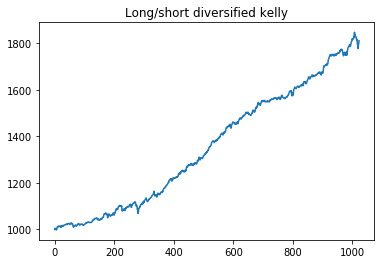

,symbol,market_datetime,prediction_mapped,actuals_mapped,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits,profit_rate,estimated_loss,kelly,half_kelly,quarter_kelly,eighth_kelly,position,n_shares,quarter_kelly_adj,sector,industry
1,AES,2014-12-09 06:00:00,13.832187,13.470000,13.650000,long,0.182187,-0.180000,0.55,0.130000,0.228901,0.114450,0.057225,0.028613,13.47,1,0,Basic Industries,Electric Utilities: Central
13,ACH,2014-12-09 06:00:00,10.771780,10.720000,11.210000,short,0.438220,0.490000,0.50,0.150000,0.328853,0.164427,0.082213,0.041107,21.44,2,0,Basic Industries,Aluminum
19,AA,2014-12-09 06:00:00,51.631768,47.760004,50.699996,long,0.931772,-2.939992,0.54,0.540001,0.273411,0.136705,0.068353,0.034176,0.00,0,0,Basic Industries,Aluminum
3,AGCO,2014-12-09 06:00:00,43.240227,43.050000,43.710000,short,0.469772,0.660000,0.57,0.355000,0.245055,0.122528,0.061264,0.030632,0.00,0,0,Capital Goods,Industrial Machinery/Components
12,ABB,2014-12-09 06:00:00,22.368532,21.420000,21.680000,long,0.688532,-0.260000,0.48,0.165000,0.355387,0.177694,0.088847,0.044423,21.42,1,0,Consumer Durables,Electrical Products


In [29]:
annualized_return = portfolio_utils.annualized_return(
    budget[0], 
    budget[-1], 
    len(budget))
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.title('Long/short diversified kelly')
plt.plot(budget)
plt.show()

positions.head()

### Benchmark against SP 500

In [30]:
query = f"""
    with temp as (
        select 
            market_datetime
            , open as open_t
            , lead(open) over (order by market_datetime) as open_t1
        from yahoo.sp_index
        where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    )
    select *, open_t1 / open_t as daily_profit
    from temp
    order by market_datetime
    """

sp = utils.query_db(query=query)
sp.head()

,market_datetime,open_t,open_t1,daily_profit
0,2005-01-03,1211.920044,1202.079956,0.991881
1,2005-01-04,1202.079956,1188.050049,0.988329
2,2005-01-05,1188.050049,1183.739990,0.996372
3,2005-01-06,1183.739990,1187.890015,1.003506
4,2005-01-07,1187.890015,1186.189941,0.998569


Annualized P/L 0.077857


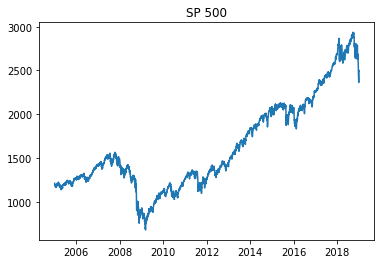

In [31]:
annualized_return = portfolio_utils.annualized_return(
    sp['open_t'].values[0], 
    sp['open_t'].values[-1], 
    len(sp))
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.title('SP 500')
plt.plot(sp['market_datetime'], sp['open_t'])
plt.show()